# IGA Upsample Mapping for 2D cases

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import h5py
import scipy.sparse as sp

**1. Define the Reference Square**
   
   This will involve specifying the points of the unit square and their parametric coordinates.
   
**2. Define the Target Quadrilateral**
   
   Input the coordinates of the quadrilateral to which you will map the unit square.

In [2]:
# Define the reference square and the target quadrilateral vertices
ref_square = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
quad_vertices = np.array([[1, 1], [3, 2], [2, 4], [0, 3]])  # Example vertices

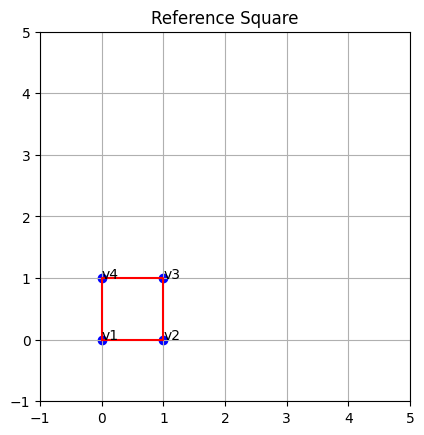

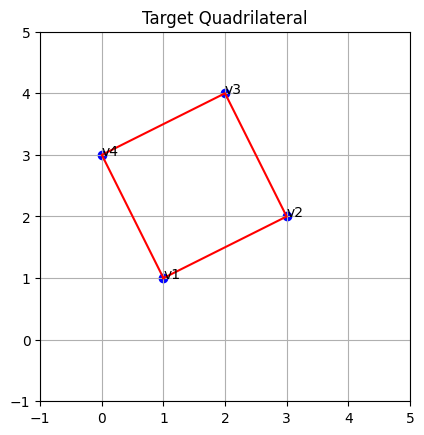

In [3]:

# Function to plot quadrilaterals
def plot_quad(vertices, title='Quadrilateral'):
    fig, ax = plt.subplots()
    quad = np.vstack([vertices, vertices[0]])  # Close the loop
    ax.plot(quad[:, 0], quad[:, 1], 'r-')
    ax.set_xlim([-1, 5])
    ax.set_ylim([-1, 5])
    ax.set_aspect('equal')
    ax.scatter(vertices[:, 0], vertices[:, 1], color='blue')
    for i, txt in enumerate(['v1', 'v2', 'v3', 'v4']):
        ax.annotate(txt, (vertices[i, 0], vertices[i, 1]))
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_quad(ref_square, 'Reference Square')
plot_quad(quad_vertices, 'Target Quadrilateral')

**3. Define the Quadratic B-spline Basis Functions**

In [59]:
# Define quadratic B-spline basis functions
def B_0(u): return (1-u)**2
def B_1(u): return 2*u*(1-u)
def B_2(u): return u**2

def tensor_product_b_spline(u, v):
    """ Compute the tensor product of 1D B-spline basis functions for 2D space. """
    basis_functions_1d_u = [B_0(u), B_1(u), B_2(u)]
    basis_functions_1d_v = [B_0(v), B_1(v), B_2(v)]
    
    basis_functions_2d = {}
    for i, fu in enumerate(basis_functions_1d_u):
        for j, fv in enumerate(basis_functions_1d_v):
            basis_functions_2d[(i, j)] = fu * fv  # Multiplying basis functions in u and v direction

    return basis_functions_2d

In [5]:
# Example usage of basis functions
u = 0.5
print("B_0 at 0.5:", B_0(u))
print("B_1 at 0.5:", B_1(u))
print("B_2 at 0.5:", B_2(u))

B_0 at 0.5: 0.25
B_1 at 0.5: 0.5
B_2 at 0.5: 0.25


In [6]:
# Bilinear interpolation for transformation
def bilinear_interp(xi, eta, vertices):
    x = (1-xi)*(1-eta)*vertices[0][0] + xi*(1-eta)*vertices[1][0] + xi*eta*vertices[2][0] + (1-xi)*eta*vertices[3][0]
    y = (1-xi)*(1-eta)*vertices[0][1] + xi*(1-eta)*vertices[1][1] + xi*eta*vertices[2][1] + (1-xi)*eta*vertices[3][1]
    return np.array([x, y])

**4. Upsample the Reference Square**

In [34]:
# Generate a grid of points in the reference square (upsampling)
num_points_per_side = 10  # Number of points per side
xi = np.linspace(0, 1, num_points_per_side)
eta = np.linspace(0, 1, num_points_per_side)

xi_grid, eta_grid = np.meshgrid(xi, eta)
xi_flat = xi_grid.flatten()
eta_flat = eta_grid.flatten()

vertices = np.column_stack((xi_flat, eta_flat)) # Upsampled vertices on the reference shape
transformed_points = np.array([bilinear_interp(x, y, quad_vertices) for x, y in zip(xi_flat, eta_flat)]) # Upsampled vertices on the target shape

In [30]:
# Define the triangles and edges for a structured grid
faces = []
edges = set()  # To avoid duplicates

for i in range(num_points_per_side - 1):
    for j in range(num_points_per_side - 1):
        bottom_left = i * num_points_per_side + j
        bottom_right = bottom_left + 1
        top_left = bottom_left + num_points_per_side
        top_right = top_left + 1
        
        # Define two triangles for each square
        faces.append([bottom_left, top_left, top_right])
        faces.append([bottom_left, top_right, bottom_right])
        
        # Add edges, ensure each edge is added once
        edges.update([
            (bottom_left, top_left), (top_left, top_right), (top_right, bottom_left),
            (bottom_left, bottom_right), (bottom_right, top_right), (top_right, bottom_left)
        ])

# Convert edges set to sorted list
ordered_edges = np.array(list(edges), dtype=np.int64)
ordered_faces = np.array(faces, dtype=np.int64)

In [39]:
# Save the upsampled target mesh
def save_mesh_as_obj(vertices, faces, filename='mesh.obj'):
    """
    Save a 2D mesh as an OBJ file.
    
    Parameters:
    - vertices: NumPy array of shape (n, 2) for vertex coordinates.
    - faces: NumPy array of shape (m, 3) for indices of vertices forming each triangle.
    - filename: String, the path where the .obj file will be saved.
    """
    with open(filename, 'w') as file:
        # Write vertices
        for vertex in vertices:
            file.write(f"v {vertex[0]} {vertex[1]} 0.0\n")
        
        # Write faces
        for face in faces:
            # OBJ files are 1-indexed
            file.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")

    print(f"Mesh saved to {filename}")

filename = '2d-quad-upsample.obj'
save_mesh_as_obj(transformed_points, faces, filename)

Mesh saved to 2d-quad-upsample.obj


In [44]:
# Save the original target mesh
def save_quadrilateral_as_obj(vertices, filename='quadrilateral.obj'):
    """
    Save a set of vertices that define a quadrilateral into an OBJ file.

    Parameters:
    - vertices: NumPy array of shape (4, 2) for vertex coordinates of the quadrilateral.
    - filename: String, the path where the .obj file will be saved.
    """
    with open(filename, 'w') as file:
        # Write vertices
        for vertex in vertices:
            # Assume z = 0 since vertices are 2D
            file.write(f"v {vertex[0]} {vertex[1]} 0.0\n")
        
        # Write face
        # OBJ file indices start at 1 and since it's a quadrilateral, we connect four vertices
        file.write("f 1 2 3 4\n")

    print(f"Quadrilateral saved to {filename}")

ori_filename = '2d-quad.obj'
save_quadrilateral_as_obj(quad_vertices, ori_filename)

Quadrilateral saved to 2d-quad.obj


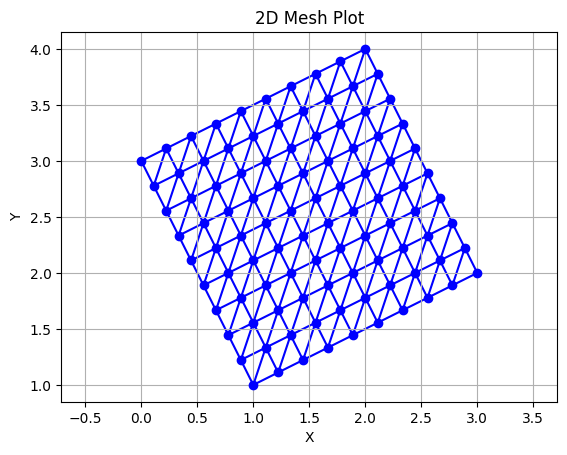

In [37]:
# Plot the upsampled target mesh
def plot_mesh(vertices, faces):
    """
    Plot a 2D mesh using matplotlib.
    
    Parameters:
    - vertices: NumPy array of shape (n, 2) for vertex coordinates.
    - faces: NumPy array of shape (m, 3) for indices of vertices forming each triangle.
    """
    fig, ax = plt.subplots()
    tri = mtri.Triangulation(vertices[:, 0], vertices[:, 1], faces)
    ax.triplot(tri, 'bo-')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('2D Mesh Plot')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_mesh(transformed_points, faces)

**5. Map Points from Reference to Quadrilateral**

    Use bilinear interpolation to map points from the reference square to the target quadrilateral based on the control points.

In [12]:
# Transform each point in the grid to the quadrilateral
transformed_points = np.array([bilinear_interp(x, y, quad_vertices) for x, y in zip(xi_flat, eta_flat)])

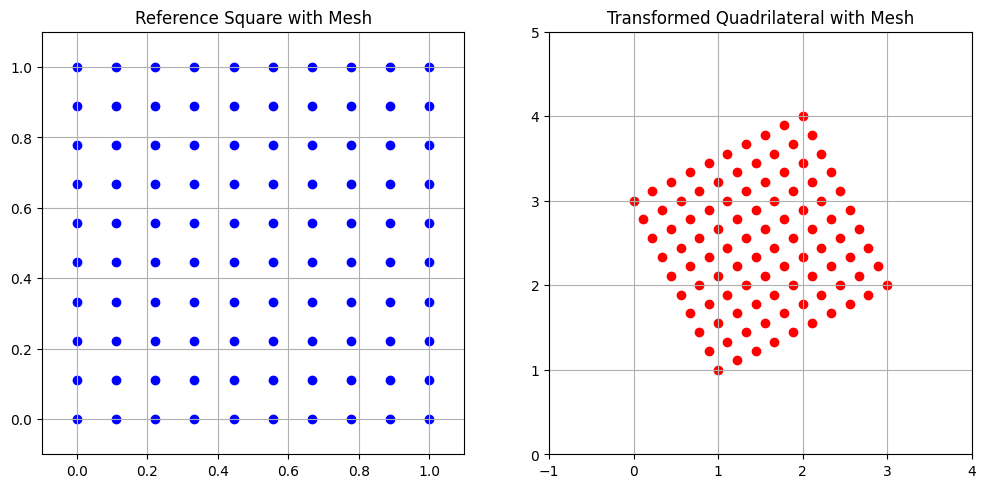

In [13]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot reference square with mesh
axs[0].scatter(xi_flat, eta_flat, color='blue')
axs[0].set_title('Reference Square with Mesh')
axs[0].set_xlim([-0.1, 1.1])
axs[0].set_ylim([-0.1, 1.1])
axs[0].set_aspect('equal')
axs[0].grid(True)

# Plot transformed quadrilateral with mesh
axs[1].scatter(transformed_points[:, 0], transformed_points[:, 1], color='red')
axs[1].set_title('Transformed Quadrilateral with Mesh')
axs[1].set_xlim([min(transformed_points[:, 0])-1, max(transformed_points[:, 0])+1])
axs[1].set_ylim([min(transformed_points[:, 1])-1, max(transformed_points[:, 1])+1])
axs[1].set_aspect('equal')
axs[1].grid(True)

plt.show()

**6. Construct W matrix**

In [62]:
# Bilinear interpolation function to calculate weights
def bilinear_weights(xi, eta):
    return np.array([
        (1 - xi) * (1 - eta),  # Weight for v1
        xi * (1 - eta),       # Weight for v2
        xi * eta,             # Weight for v3
        (1 - xi) * eta        # Weight for v4
    ])

# Compute weights for each point in the mesh
W = np.array([bilinear_weights(x, y) for x, y in zip(xi_flat, eta_flat)])

print(W.shape)

(100, 4)


In [63]:
### Should use this!!!!!!
def tensor_product_b_spline_weights(u, v):
    """ Compute the tensor product of 1D B-spline basis functions for 2D space. """
    basis_functions_1d_u = [B_0(u), B_1(u), B_2(u)]
    basis_functions_1d_v = [B_0(v), B_1(v), B_2(v)]
    
    weights = np.zeros((3, 3))  # Assuming a 3x3 control point grid for quadratic B-splines
    for i in range(3):
        for j in range(3):
            weights[i, j] = basis_functions_1d_u[i] * basis_functions_1d_v[j]

    return weights.flatten()

# Now compute weights for each point in the mesh using the new basis function weights
W = np.array([tensor_product_b_spline_weights(x, y) for x, y in zip(xi_flat, eta_flat)])

print(W.shape)

(100, 9)


In [61]:
# Visualize the transformation by plotting the reference and target quadrilaterals with mesh points
transformed_points = np.dot(W, quad_vertices)  # Transform points by weights

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot reference square with mesh
axs[0].scatter(xi_flat, eta_flat, color='blue')
axs[0].set_title('Reference Square with Mesh')
axs[0].set_xlim([-0.1, 1.1])
axs[0].set_ylim([-0.1, 1.1])
axs[0].set_aspect('equal')
axs[0].grid(True)

# Plot transformed quadrilateral with mesh
axs[1].scatter(transformed_points[:, 0], transformed_points[:, 1], color='red')
axs[1].set_title('Transformed Quadrilateral with Mesh')
axs[1].set_xlim([min(transformed_points[:, 0])-1, max(transformed_points[:, 0])+1])
axs[1].set_ylim([min(transformed_points[:, 1])-1, max(transformed_points[:, 1])+1])
axs[1].set_aspect('equal')
axs[1].grid(True)

plt.show()

ValueError: shapes (100,9) and (4,2) not aligned: 9 (dim 1) != 4 (dim 0)

In [67]:
# Print aprt of the weights matrix W for verification
print("Matrix W (first few rows):")
print(W[:5])

Matrix W (first few rows):
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.79012346 0.         0.         0.19753086 0.         0.
  0.01234568 0.         0.        ]
 [0.60493827 0.         0.         0.34567901 0.         0.
  0.04938272 0.         0.        ]
 [0.44444444 0.         0.         0.44444444 0.         0.
  0.11111111 0.         0.        ]
 [0.30864198 0.         0.         0.49382716 0.         0.
  0.19753086 0.         0.        ]]


In [65]:
# Save the weights matrix W in a sparse format as .hdf5

# Convert W to a sparse matrix in COO format
W_sparse = sp.coo_matrix(W)

# Extract non-zero entries for saving in sparse format
rows = W_sparse.row
cols = W_sparse.col
values = W_sparse.data

map_filename = '2d-quad-map.hdf5'

# Save to HDF5
with h5py.File(map_filename, 'w') as f:
    # Save edges and faces with explicit data types
    f.create_dataset('ordered_edges', data=ordered_edges, dtype=np.int64)
    f.create_dataset('ordered_faces', data=ordered_faces, dtype=np.int64)
    
    # Save the weight triplets
    weight_group = f.create_group('weight_triplets')
    weight_group.attrs['shape'] = np.array(W_sparse.shape)  # Store the shape of the original matrix W
    weight_group.create_dataset('cols', data=W_sparse.col, dtype=np.int32)  # Column indices from COO
    weight_group.create_dataset('rows', data=W_sparse.row, dtype=np.int32)  # Row indices from COO
    weight_group.create_dataset('values', data=W_sparse.data, dtype=np.float64)  # Non-zero values from COO

print(f"Data saved successfully in {map_filename}")

Data saved successfully in 2d-quad-map.hdf5


In [71]:
# Create full indices for every element in W
rows, cols = np.indices(W.shape)
values = W.flatten()  # Flatten the matrix values to a 1D array

# Convert indices to 1D arrays for storage
rows = rows.flatten()
cols = cols.flatten()

with h5py.File(map_filename, 'w') as f:
    # Save edges and faces with explicit data types
    f.create_dataset('ordered_edges', data=ordered_edges, dtype=np.int64)
    f.create_dataset('ordered_faces', data=ordered_faces, dtype=np.int64)
    
    # Save the weights in the format similar to sparse matrix storage
    weight_group = f.create_group('weight_triplets')
    weight_group.attrs['shape'] = np.array(W.shape)  # Store the shape of the original matrix W
    weight_group.create_dataset('cols', data=cols.astype(np.int32))  # Column indices from W
    weight_group.create_dataset('rows', data=rows.astype(np.int32))  # Row indices from W
    weight_group.create_dataset('values', data=values, dtype=np.float64)  # Values from W

print(f"Data saved successfully in {map_filename}")

Data saved successfully in 2d-quad-map.hdf5
